In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from google.colab import drive
drive.mount('/drive')
import warnings
warnings.filterwarnings("ignore")

Mounted at /drive


In [ ]:
def plot_logodds(df_cal):
    _fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(np.array(df_cal.index),df_cal.predicted_logodds.values,color='blue',label='predicted_logodds')
    ax1.set_ylabel('Predicted Logodds')

    ax2.plot(np.array(df_cal.index),df_cal.actual_logodds.values,color='red',label='actual_logodds')
    ax2.set_ylabel('Actual Logodds')

    plt.legend()
    plt.show()


def perform_regression_calibration(df_cal, nbr_bins=5):
    X_cal = df_cal.predicted_logodds.values.reshape((nbr_bins, 1))
    y_cal = df_cal.actual_logodds.values

    lr = LinearRegression().fit(X_cal, y_cal)
    logodd_calib_factor = lr.coef_[0]
    logodd_calib_offset = lr.intercept_
    R2 = lr.score(X_cal, y_cal)

    print('Logodds Calib Factor: ', logodd_calib_factor)
    print('Logodds Calib Offset: ', logodd_calib_offset)
    print('R2 Score:', R2)

    return logodd_calib_factor, logodd_calib_offset, R2


def tabulate_odds(pred_proba, target, nbr_bins=5):

    temp_df = pd.DataFrame( {'bad_proba': target, 'pred_proba': pred_proba})
    temp_df['good_proba'] = 1 - pred_proba  # higher the better
    temp_df['score_bin'] = pd.qcut(temp_df['good_proba'], nbr_bins, labels=range(1, nbr_bins + 1))
    temp_df['count'] = 1

    df_cal = (temp_df[['score_bin', 'good_proba', 'bad_proba', 'count']].groupby('score_bin').agg({'good_proba': ['mean'], 'bad_proba': ['mean', 'sum'], 'count': ['sum']}).reset_index())
    df_cal.columns = ['score_bin', 'avg_pred_score', 'bad_rate', 'bads', 'count']
    df_cal['goods'] = df_cal['count'] - df_cal['bads']
    df_cal['odds'] = (df_cal['goods'] / df_cal['bads']).astype('float')
    df_cal['actual_logodds'] = np.log(df_cal['odds'])
    df_cal['predicted_logodds'] = np.log((df_cal.avg_pred_score.values / (1.0 - df_cal.avg_pred_score.values)).astype('float'))

    df_cal.set_index('score_bin', inplace=True)

    return df_cal

## Preparing Data

In [ ]:
df_train = pd.read_pickle('/drive/My Drive/home-credit-default-risk/fekdi_train_using_MEV.pkl')

In [ ]:
df_test = pd.read_pickle('/drive/My Drive/home-credit-default-risk/fekdi_test_using_MEV.pkl')

In [ ]:
df_train_cal = df_train[['default_flag','proba_default']]

In [ ]:
df_test_cal = df_test[['default_flag','proba_default']]

## Callibration

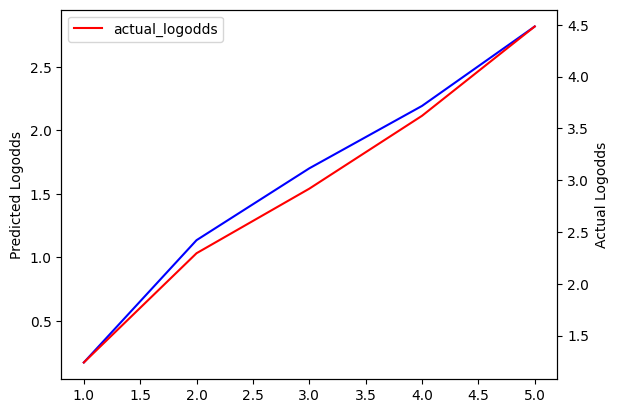

In [ ]:
df_cal = tabulate_odds(df_train_cal['proba_default'],df_train_cal['default_flag'])
plot_logodds(df_cal)

In [ ]:
df_cal

,avg_pred_score,bad_rate,bads,count,goods,odds,actual_logodds,predicted_logodds
score_bin,,,,,,,,
1,0.542838,0.224316,11000,49038,38038,3.458000,1.240690,0.171773
2,0.756707,0.091541,4489,49038,44549,9.924037,2.294960,1.134711
3,0.845553,0.051288,2515,49037,46522,18.497813,2.917653,1.700141
4,0.899492,0.026061,1278,49038,47760,37.370892,3.620892,2.191588
5,0.943588,0.011175,548,49038,48490,88.485401,4.482838,2.817011


In [ ]:
callibration = {}
callibration['factor'], callibration['offset'], callibration['R2'] = perform_regression_calibration(df_cal)

Logodds Calib Factor:  1.2216979337893148
Logodds Calib Offset:  0.9529696738001168
R2 Score: 0.9953539317379808


## Scoring

In [ ]:
def perform_score_calib(pred, calibration, risk_factor=72.1, risk_offset=200):
    odds_m = calibration['factor']
    odds_c = calibration['offset']
    predicted_log_odds = np.log((1 - pred) / pred)
    score = odds_m * predicted_log_odds + odds_c
    score = risk_factor * score + risk_offset
    return score

In [ ]:
df_train['score'] = perform_score_calib(df_train_cal['proba_default'],callibration)
df_test['score'] = perform_score_calib(df_test_cal['proba_default'],callibration)

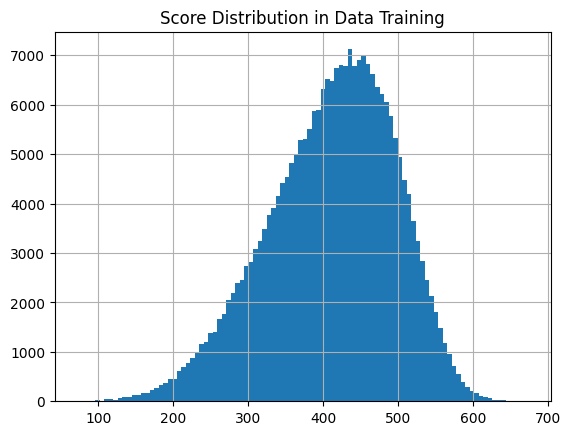

In [ ]:
df_train['score'].hist(bins=100)
plt.title('Score Distribution in Data Training')
plt.show()

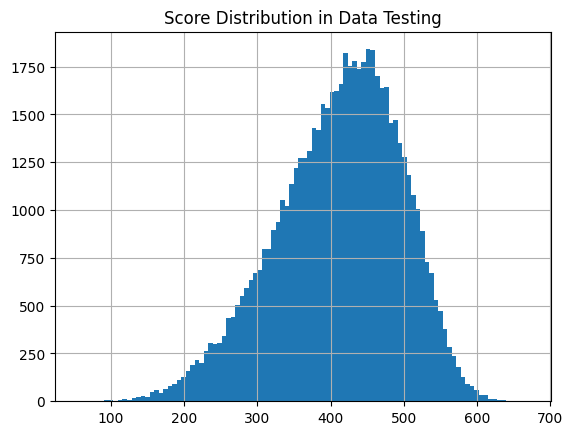

In [ ]:
df_test['score'].hist(bins=100)
plt.title('Score Distribution in Data Testing')
plt.show()

In [ ]:
def get_bad_rate_cutoff(df,target_column='actual',score_column='score',cutoff_lvl=50,cutoff_low=200,cutoff_high=800):
  df['cut_score'] = df[score_column].apply(lambda x: cutoff_low if x <= cutoff_low else x)
  df['cut_score'] = df[score_column].apply(lambda x: cutoff_high if x >= cutoff_high else x)
  df['Score Range'] = pd.cut(df['cut_score'],bins=[-np.inf] + np.arange(cutoff_low,cutoff_high,cutoff_lvl).tolist() + [np.inf],right=False,include_lowest=False,duplicates='drop')
  cols_req = ['Score Range',target_column,score_column]
  agg_dict = {score_column:'mean',target_column:['sum','count','mean']}
  final_cols = ['Score Range','Average Score','Bads','Total','Bad Rate']
  group_by_cols = ['Score Range']

  df_score_bin = pd.DataFrame(df[cols_req].groupby(group_by_cols).agg(agg_dict).reset_index().values,columns=final_cols)
  df_score_bin['Bad Rate'] = df_score_bin['Bad Rate'].apply(lambda x: x*100)
  df_score_bin['Goods'] = (df_score_bin['Total']-df_score_bin['Bads'])
  #df_score_bin['Odds'] = (df_score_bin['Goods'] / df_score_bin['Bads']).astype('float')
  #df_score_bin['Log Odds'] = np.log(df_score_bin['Odds'])

  return df_score_bin

In [ ]:
df_score = get_bad_rate_cutoff(df_test,target_column='default_flag',score_column='score',cutoff_lvl=100,cutoff_low=200,cutoff_high=700)
df_score

,Score Range,Average Score,Bads,Total,Bad Rate,Goods
0,"[-inf, 200.0)",171.43484,310,697,44.476327,387
1,"[200.0, 300.0)",262.317503,1494,6103,24.479764,4609
2,"[300.0, 400.0)",356.706195,1994,18653,10.689969,16659
3,"[400.0, 500.0)",448.496613,1057,26930,3.924991,25873
4,"[500.0, 600.0)",529.436892,102,8779,1.161864,8677
5,"[600.0, inf)",615.438012,1,136,0.735294,135


In [ ]:
df_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,proba_default,default_flag,score
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
396875,0,67500.0,436032.0,21339.0,360000.0,0.008068,-20951,NaN,-4220.0,-3563,...,False,False,False,False,False,False,False,0.334838,0,329.168737
416211,0,90000.0,247500.0,13950.0,247500.0,0.028663,-17806,-993.0,-10040.0,-1344,...,False,False,False,False,False,False,False,0.061620,0,508.578327
251674,0,108000.0,344043.0,12879.0,297000.0,0.020246,-21125,NaN,-12167.0,-4029,...,False,False,False,False,False,False,False,0.368953,0,315.984930
421574,1,202500.0,450000.0,21109.5,450000.0,0.006296,-11052,-1214.0,-4826.0,-2499,...,False,False,False,False,False,False,False,0.112455,0,450.682930
241698,0,180000.0,1372500.0,36202.5,1372500.0,0.007120,-22656,NaN,-13628.0,-4300,...,False,False,False,True,False,True,False,0.131785,0,434.772063


In [ ]:
df_full = pd.concat([df_train,df_test])
df_full = df_full.reset_index()
df_full.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,proba_default,default_flag,score,cut_score,Score Range
0,396875,0,67500.0,436032.0,21339.0,360000.0,0.008068,-20951,NaN,-4220.0,...,False,False,False,False,False,0.334838,0,329.168737,NaN,NaN
1,416211,0,90000.0,247500.0,13950.0,247500.0,0.028663,-17806,-993.0,-10040.0,...,False,False,False,False,False,0.061620,0,508.578327,NaN,NaN
2,251674,0,108000.0,344043.0,12879.0,297000.0,0.020246,-21125,NaN,-12167.0,...,False,False,False,False,False,0.368953,0,315.984930,NaN,NaN
3,421574,1,202500.0,450000.0,21109.5,450000.0,0.006296,-11052,-1214.0,-4826.0,...,False,False,False,False,False,0.112455,0,450.682930,NaN,NaN
4,241698,0,180000.0,1372500.0,36202.5,1372500.0,0.007120,-22656,NaN,-13628.0,...,False,True,False,True,False,0.131785,0,434.772063,NaN,NaN


In [ ]:
df_full.to_csv('/drive/My Drive/home-credit-default-risk/fekdi_baseline_wit_mev.csv')